In [1]:
import sys
import os

current_dir = os.path.dirname(os.path.abspath('__file__'))

project_root = os.path.abspath(os.path.join(current_dir, '..'))

if project_root not in sys.path:
    sys.path.insert(0, project_root)

from utils.utils import load_image, apply, display_image, display_image_comparison, rgb_to_grayscale

# Chapter 3: Halftoning

**Halftoning** is a technique that simulates *continuous-tone* imagery through the use of dots. The image generated by the halftoning process is called a *halftone*.

Halftoning is useful in print media, since images are encoded in "continuous" values (varrying shades), but printers only have a limited number of ink colors.

## Halftoning Algorithm (Error Diffusion)

Let:
-  $\mathbf{I}$: Input image
-  $T$: Threshold value  ($t \in {0,1, \dots, 255}$)
-  $\mathbf{W}$: Error diffusion kernel

The error diffusion kernel used is the *Floyd-Steinberg* kernel:
$$
    W[i, j] =
    \begin{bmatrix}
      & * & \frac{7}{16} \\
    \frac{3}{16} & \frac{5}{16} & \frac{1}{16}
    \end{bmatrix},
$$
where the star ($*$) indicates the current pixel being scanned.

For an image $\mathbf{I}$ of size $M \times N$:

1. Set $\mathbf{I}'[x,y] = \mathbf{I}[x,y] \, \, \, \forall[x,y]$
2. For each pixel $[x,y] \in \mathbf{I}$:
    1. Quantize the current pixel value to produce $\mathbf{Q}[x,y]$:
      $$
           \mathbf{Q}[x, y] =
            \begin{cases}
            0, & \text{if } \mathbf{I}'[x, y] < T, \\
            255, & \text{if } \mathbf{I}'[x, y] \geq T,
            \end{cases}
      $$
   2. Compute the quantization error at the current pixel $\mathbf{E}[x,y]$:
      $$
          \mathbf{E}[x, y] = \mathbf{I}'[x, y] - \mathbf{Q}[x, y]
      $$
   3. Distribute error:
      $$
          \mathbf{I}'[x + i, y + j] = \mathbf{I}'[x + i, y + j] + \mathbf{E}[x, y] \cdot \mathbf{W}[i, j] \hspace{0.5cm} \forall [i,j] \in \mathbf{W}
      $$

### Implementation

In [2]:
import numpy as np

In [3]:
def error_diffusion(I: np.ndarray, T: int) -> np.ndarray:
    M, N = I.shape

    Q = np.zeros((M, N), dtype=np.uint8)
    E = np.zeros((M, N), dtype=np.float64)
    W = np.array([
        [0,     0,   7/16],
        [3/16, 5/16, 1/16]
    ])

    I_prime = I.astype(np.float64).copy()

    for y in range(M):
        for x in range (N):

            if I_prime[y, x] < T:
                Q[y, x] = 0
            else:
                Q[y, x] = 255
            
            E[y, x] = I_prime[y, x] - Q[y, x]
            
            for j in range(2):
                for i in range(3):

                    if W[j, i] == 0:
                        continue 
                        
                    y_prime, x_prime = y + j-1, x + i
                    if 0 <= y_prime < N and 0 <= x_prime < M: 
                        I_prime[y_prime, x_prime] += E[y, x] * W[j, i]

    return Q

### Examples

#### Example 1

In [4]:
image_1_path = "../TEST-IMAGES/OLD-CLASSIC/cameraman.pgm"
image_1 = load_image(image_1_path)

Image Metadata for 'cameraman.pgm':
 - Format: PPM
 - Size on Disk: 64.04 KB
 - Dimensions: 256x256 pixels
 - Mode: L
 - Channels: 1


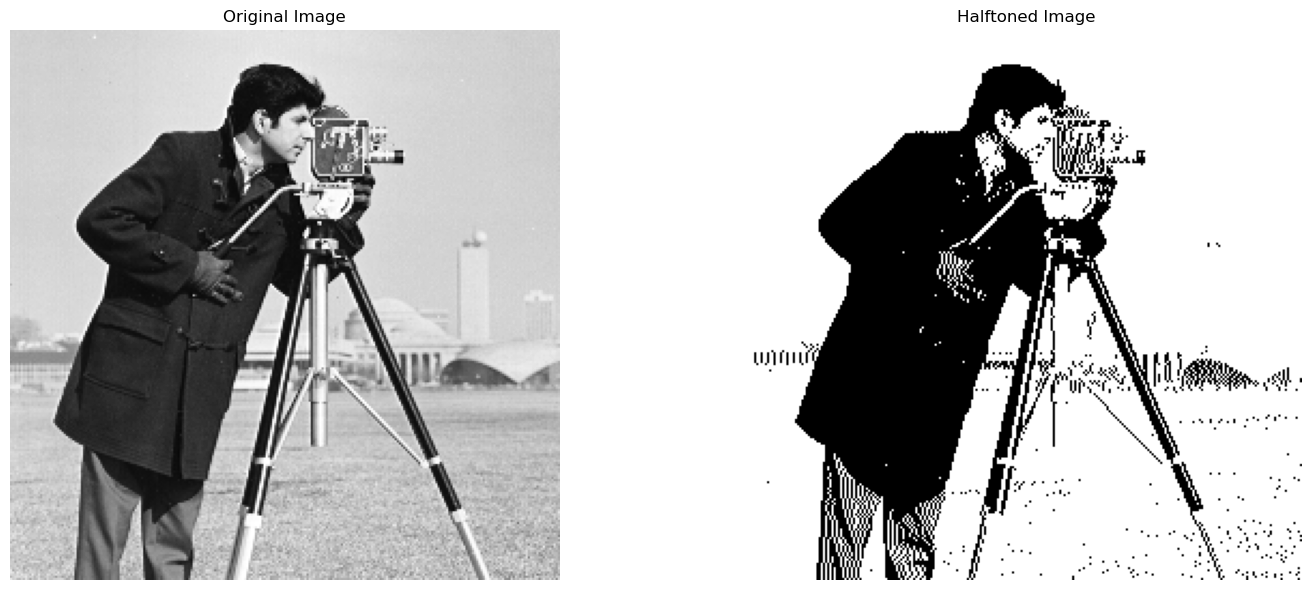

In [5]:
halftoned_image_1 = apply(image_1, error_diffusion, T=128)
display_image_comparison(image_1, halftoned_image_1, 'Original Image', 'Halftoned Image')

We can also compare how different thresholding values may affect the resulting image

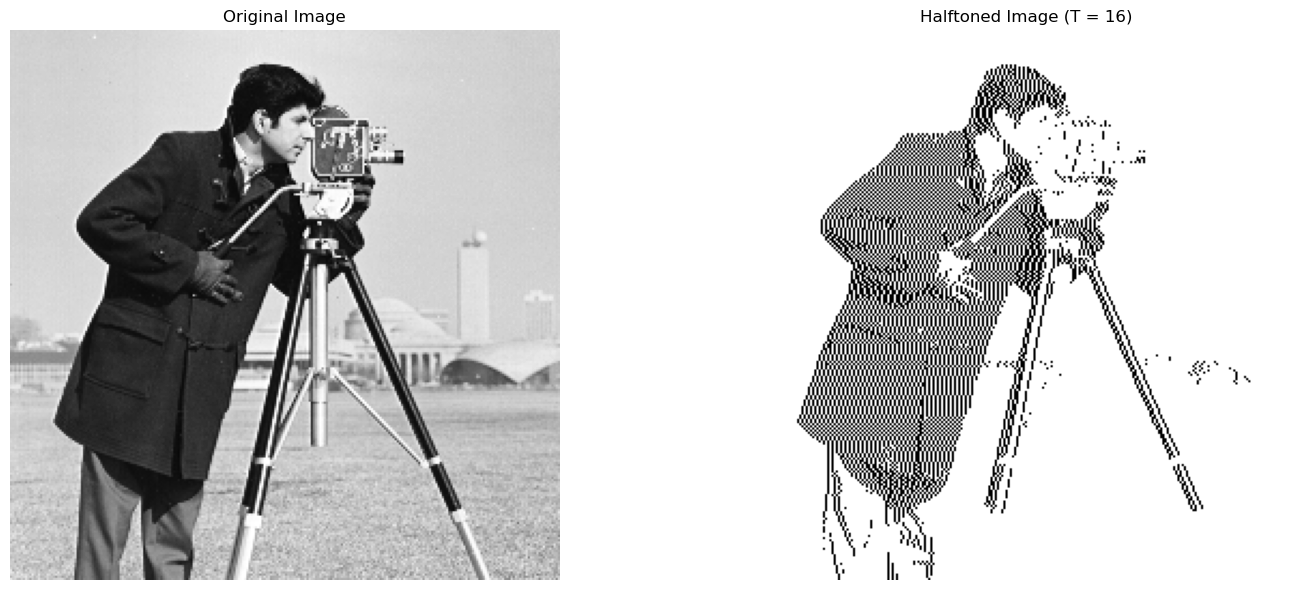

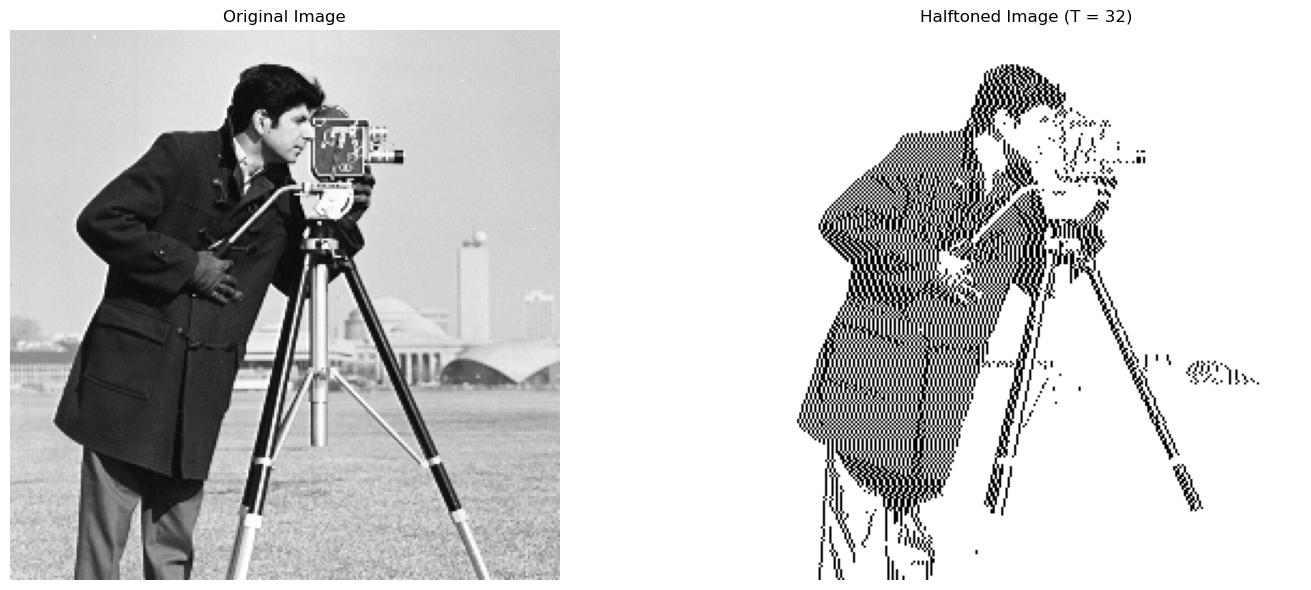

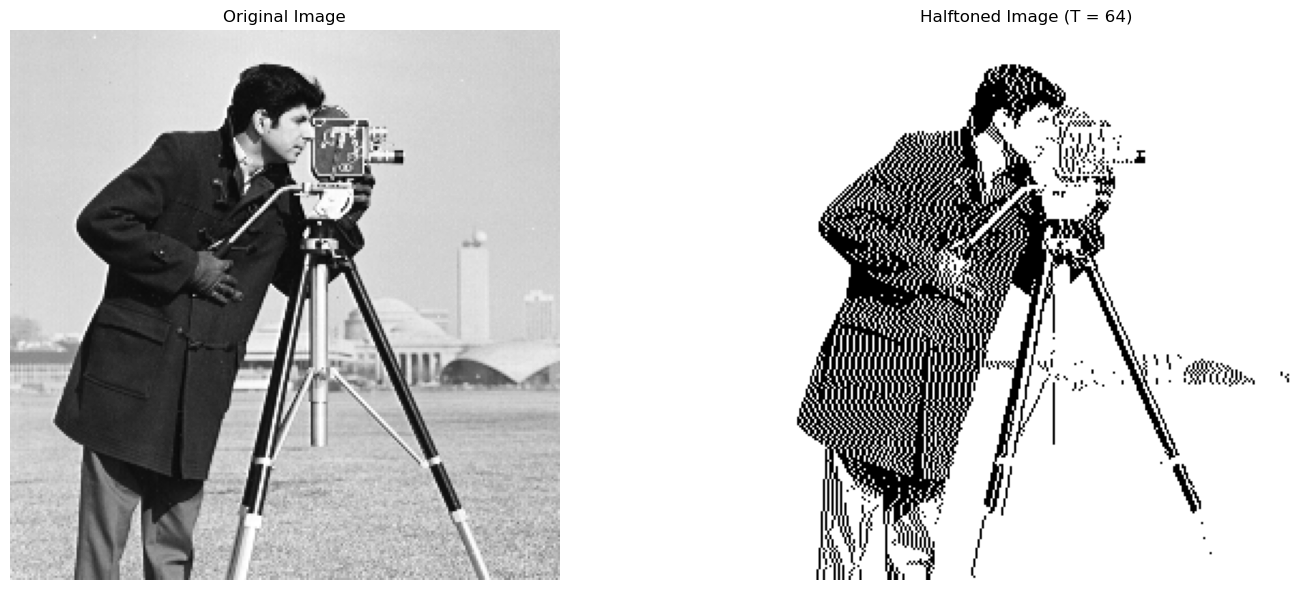

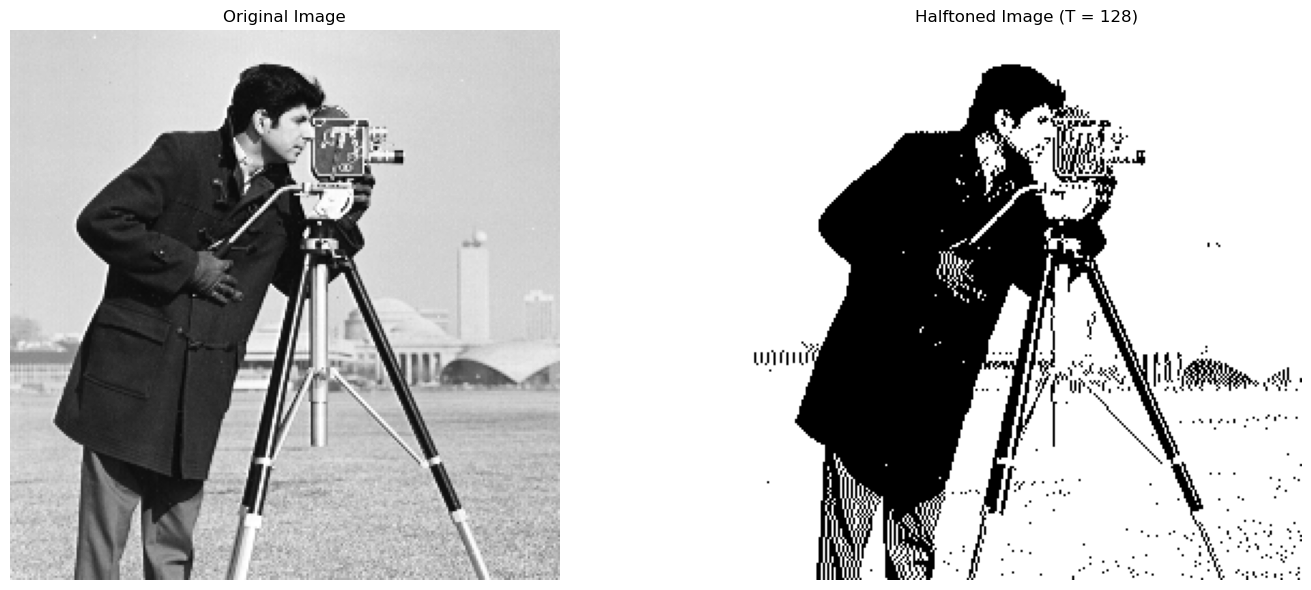

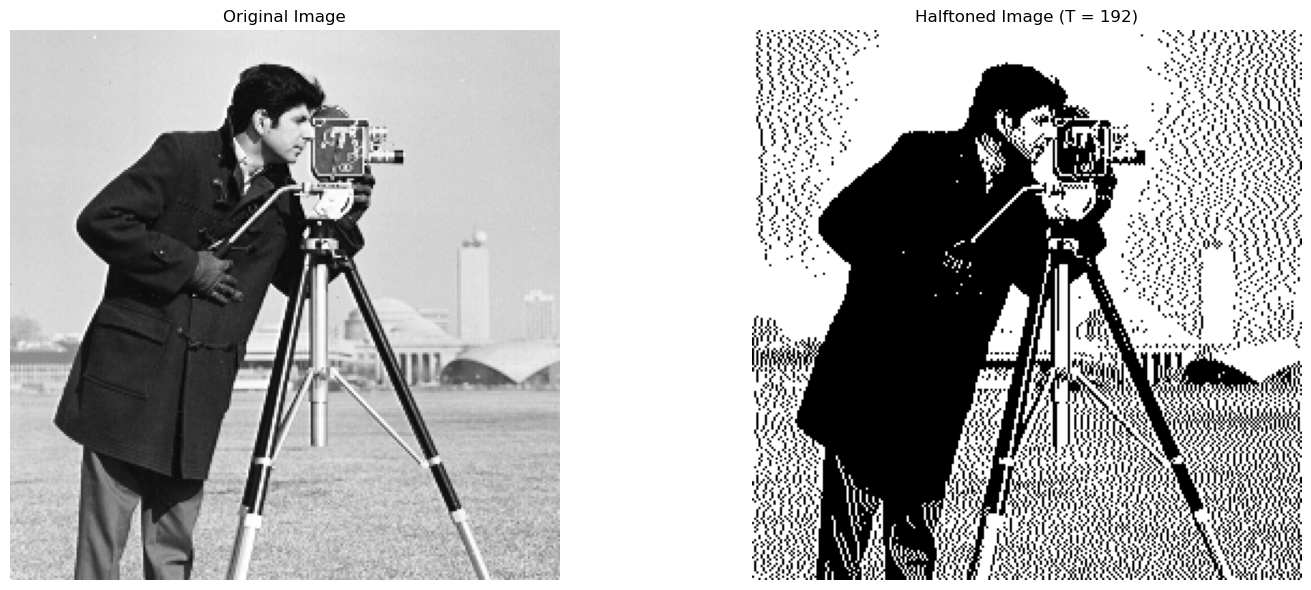

In [6]:
operations = [
    {'func': error_diffusion, 'params': {'T': 16}},
    {'func': error_diffusion, 'params': {'T': 32}},
    {'func': error_diffusion, 'params': {'T': 64}},
    {'func': error_diffusion, 'params': {'T': 128}},
    {'func': error_diffusion, 'params': {'T': 192}}
]

for op in operations:
    halftoned_image = apply(image_1, op['func'], **op['params'])
    display_image_comparison(image_1, halftoned_image, 'Original Image', f"Halftoned Image (T = {op['params']['T']})")

#### Example 2

In [7]:
image_2_path = "../TEST-IMAGES/CLASSIC/goldhill.ppm"
image_2 = load_image(image_2_path)

Image Metadata for 'goldhill.ppm':
 - Format: PPM
 - Size on Disk: 1215.01 KB
 - Dimensions: 720x576 pixels
 - Mode: RGB
 - Channels: 3


Since the image in this example is in RGB mode, it must first be converted to greyscale.

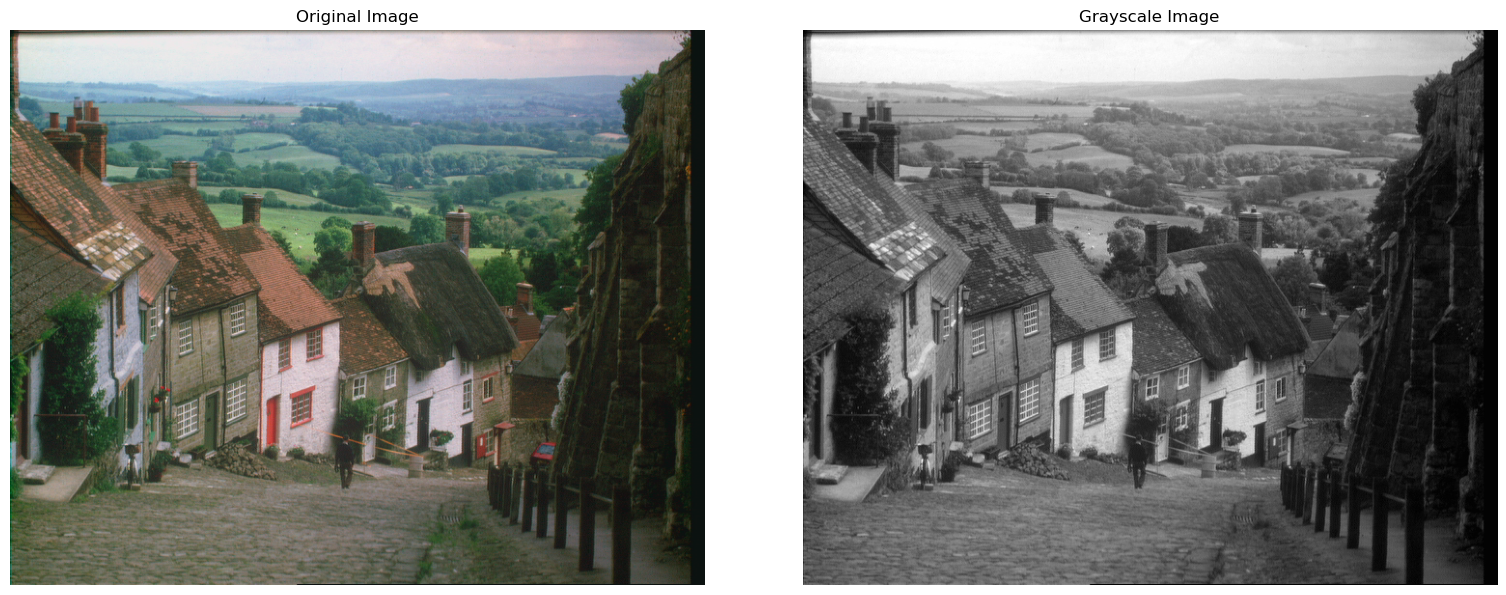

In [8]:
grayscale_image_2 = apply(image_2, rgb_to_grayscale)
display_image_comparison(image_2, grayscale_image_2, 'Original Image', 'Grayscale Image')

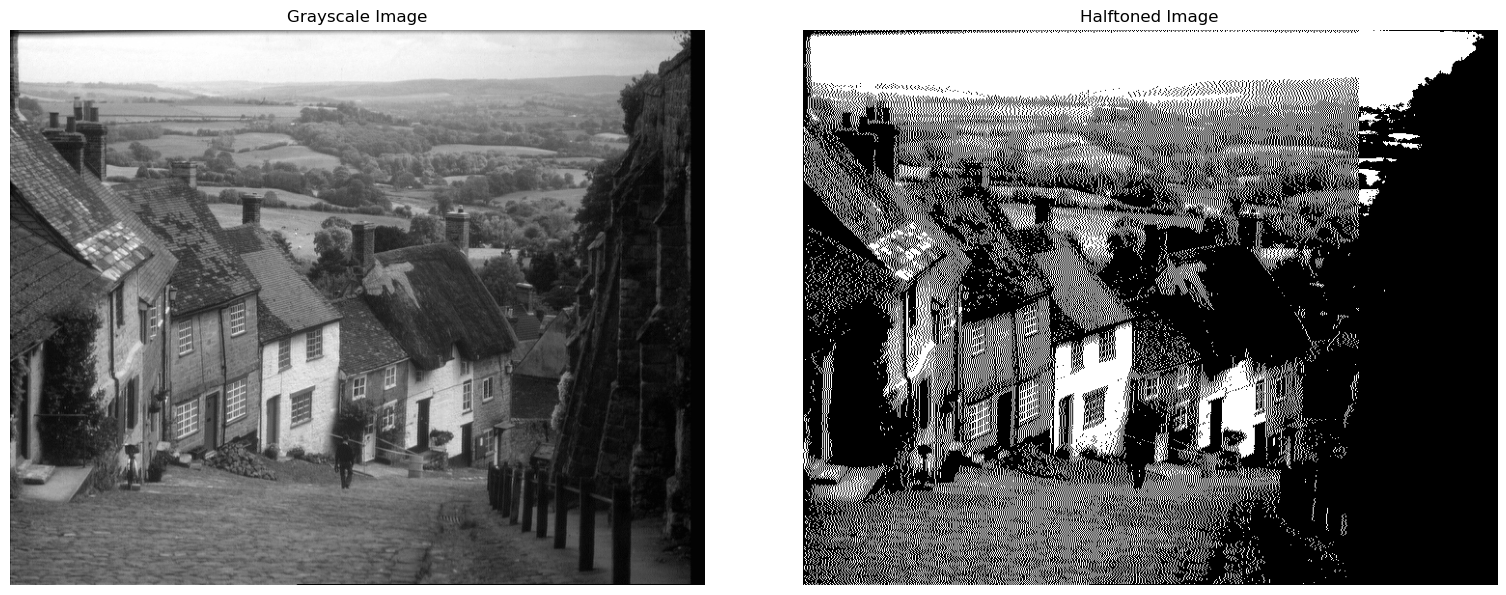

In [9]:
halftoned_image_2 = apply(grayscale_image_2, error_diffusion, T=128)
display_image_comparison(grayscale_image_2, halftoned_image_2, 'Grayscale Image', 'Halftoned Image')

In this example the artifacts produced by error diffusion are much more clear. Notice the "grid lines" that are produced in the halftoned image. The artifacts are a remenant of the kernel "moving" over the different regions in the image, you can image a larger kernel producing a grid with larger squares.

One way to prevent this artifcact might be to alternate the the pattern when processing the image i.e.. instead of always moving from left -> right during error diffusion alternate between left -> right and right -> left on every other row.